In [1]:
from __future__ import division
import numpy as np
import scipy as sp
from scipy.integrate import odeint
from scipy import stats
from scipy import interpolate
import math
import matplotlib.pyplot as plt
import pandas as pd # to read excel
print(f"pandas version is {pd.__version__}")
import seaborn as sns
from array import *
import researchpy as rp
import scipy.stats as stats
%matplotlib inline

from myfunctions_controlled_conditions import *

import datetime

pandas version is 1.0.1


In [2]:
# Read data and parameters from excel files

x1 = pd.ExcelFile('C:/Users/meiro/Desktop/GitHub/Model/Meiron_model/data/Parameters.xlsx')
x2 = pd.ExcelFile('C:/Users/meiro/Desktop/GitHub/Model/Meiron_model/data/Data.xlsx')

# Import parameters into df1
df1 = x1.parse('Parameters')

# assigmment of parameters to values: 
for key,val in zip(df1.Parameter,df1.Indoor_value):
    exec(key + '=val')
    print(key,val)

# Import data into df2
df2 = x2.parse('Indoor')

df2.head()

umol_to_percent_DW 0.0014
n_days 7.0
Duration 7.0
Nint0 1.85
m0 0.15
Nintcrit 4.5
miu 0.04
Nintmax 5.5
Nintmin 0.48
Ks 14.0
Vmax 60.0
Z 0.178
KI 35.0
K0 0.5
Ka 0.05
Topt 18.0
Tmin 5.0
Tmax 35.0
n 5.0
losses20 0.0016
teta 1.047
Sopt 25.0
Smin 3.0
Smax 48.0
Shigh 30.0
Slow 12.0
KN 1.1
dNextoutdt 0.014
dNextindt 0.0
dmoutdt 0.0
Next00  4032.0
dilution 0.0


,Sample,Exp,Sleeve,Week,Stage,Timei,Timeh,Time,DW,mmi,...,Frequency,Amplitude,Duration,Flux,Sporulated,Comment,Day,Comment2,Unnamed: 38,N_Saturation
0,0.0,1,0,0.0,i,"2019,3,12,13,0","2019,3,12,13,0","2019,3,12,13,0",0.750,NaN,...,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,yes
1,0.7,1,0,0.0,f,"2019,3,12,13,0","2019,3,12,13,0","2019,3,19,13,0",0.753,50.0,...,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,yes
2,1.0,1,1,1.0,i,"2019,3,19,13,0","2019,3,19,13,0","2019,3,19,13,0",0.144,NaN,...,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN,NaN,yes
3,2.0,1,2,1.0,i,"2019,3,19,13,0","2019,3,19,13,0","2019,3,19,13,0",0.153,NaN,...,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN,NaN,yes
4,3.0,1,3,1.0,i,"2019,3,19,13,0","2019,3,19,13,0","2019,3,19,13,0",0.159,NaN,...,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN,NaN,yes


In [3]:
# Process data

# Convert Time (from a form of YYYY,M,DD,HH,mm) into hours (from begining of experiment)

T = []
for i in df2['Sample'][:]:
    T1 = df2['Timei'][df2['Sample'].values.tolist().index(i)]
    T2 = df2['Time'][df2['Sample'].values.tolist().index(i)]
    T.append(Time_to_Hours(T1,T2))
df2['T'] = T

# Make a temp DF (df2_Reduced) by filtering the original df - removing data of:
# 1. acclimation stage, 2. begining of experiments (which is constant), and 3. weeks above 3 (irrelevant here), and other irrelevant data that was excluded

df2_Reduced = df2[(df2.Treatment != 'Acclimation') & (df2.Week <= 2) & (df2.Stage != 'i') &(df2.Comment != 'Exclude')]

df2_Reduced

,Sample,Exp,Sleeve,Week,Stage,Timei,Timeh,Time,DW,mmi,...,Amplitude,Duration,Flux,Sporulated,Comment,Day,Comment2,Unnamed: 38,N_Saturation,T
11,1.7,1,1,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.408,4.8,...,1000.0,168.0,1000.0,No,NaN,NaN,NaN,NaN,yes,165
12,2.7,1,2,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.426,5.1,...,1000.0,168.0,1000.0,No,NaN,NaN,NaN,NaN,yes,165
13,3.7,1,3,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.330,5.3,...,1000.0,168.0,1000.0,No,NaN,NaN,NaN,NaN,yes,165
14,4.7,1,4,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.267,5.2,...,2000.0,4.0,2000.0,No,NaN,NaN,NaN,NaN,no,165
15,5.7,1,5,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.267,4.8,...,2000.0,4.0,2000.0,No,NaN,NaN,NaN,NaN,no,165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,135.7,5,5,2.0,f,"2019,11,28,12,0","2019,12,5,13,0","2019,12,12,12,0",0.477,5.0,...,500.0,168.0,1500.0,No,NaN,NaN,NaN,NaN,yes,336
451,136.7,5,6,2.0,f,"2019,11,28,12,0","2019,12,5,13,0","2019,12,12,12,0",0.375,5.0,...,500.0,168.0,1500.0,No,NaN,NaN,NaN,NaN,yes,336
452,137.7,5,7,2.0,f,"2019,11,28,12,0","2019,12,5,13,0","2019,12,12,12,0",0.378,4.0,...,200.0,168.0,1000.0,No,NaN,NaN,NaN,NaN,yes,336
453,138.7,5,8,2.0,f,"2019,11,28,12,0","2019,12,5,13,0","2019,12,12,12,0",0.336,5.0,...,200.0,168.0,1000.0,No,NaN,NaN,NaN,NaN,yes,336


In [4]:
# list of parameters - based on multi-system culibration
miu = 0.03
lossess20 = 0.004
Nintmax = 4.5
Nintcrit = 2.3 
dNextoutdt = 0.015
Ks = 23
Vmax = 60
KI = 16
K0 = 2
Ka = 0.1
Smin = 0
Sopt = 28
Smax = 50
Topt = 18
Tmax = 35.9
n = 5.1

In [5]:
# list of parameters - based on indoor system culibration
miu = 0.03
lossess20 = 0.004
Nintmax = 4.2
Nintcrit = 2.8
dNextoutdt = 0.01
Ks = 25.6
Vmax = 54.5
KI = 21.7
K0 = 1.4
Ka = 0.018
Smin = 0.8
Sopt = 23.1
Smax = 45.4
Topt = 19.8
Tmax = 34.4
n = 5.2

In [6]:
# list of parameters - based on indoor system culibration - Nintmax between 4.5-5
miu = 0.03
lossess20 = 0.001
Nintmax = 4.8
Nintcrit = 1.55
dNextoutdt = 0.013
Ks = 12.1
Vmax = 53.2
KI = 32.9
K0 = 1.3
Ka = 0.033

C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Boolean Series key will be reindexed to match DataFrame index.



Treatment: 2000/1/4
0
Starting point
4.0
Duration
168.0
Second week
172.0
Duration
336.0
Fertilizing efficiency of: -0.004954009579973441

Treatment: 500/1/4
0
Starting point
4.0
Duration
168.0
Second week


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


172.0
Duration
336.0
Fertilizing efficiency of: -0.020338541651938904
0
The RMSRE of m in treamtment 2000/1/4 is: 0.391

The RMSRE of Nint in treamtment 2000/1/4 is: 0.256

1
The RMSRE of m in treamtment 500/1/4 is: 0.38

The RMSRE of Nint in treamtment 500/1/4 is: 0.408



C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:217: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


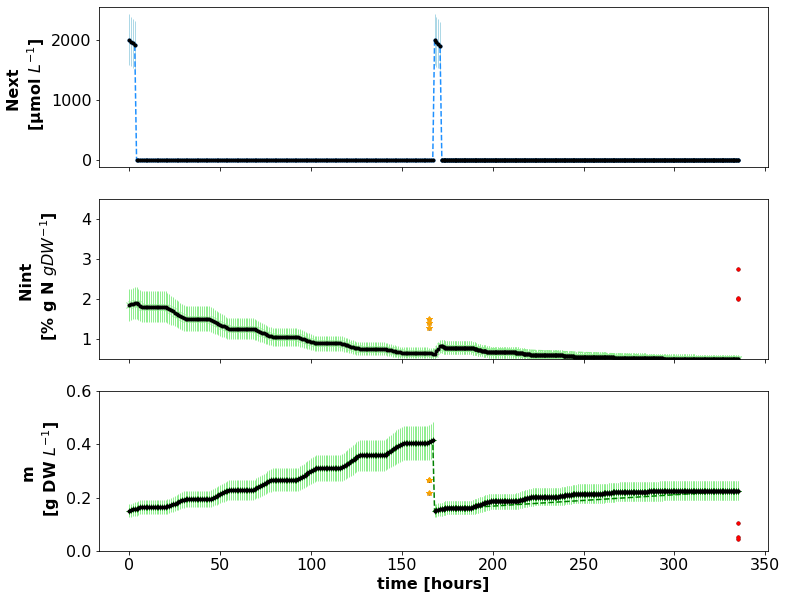

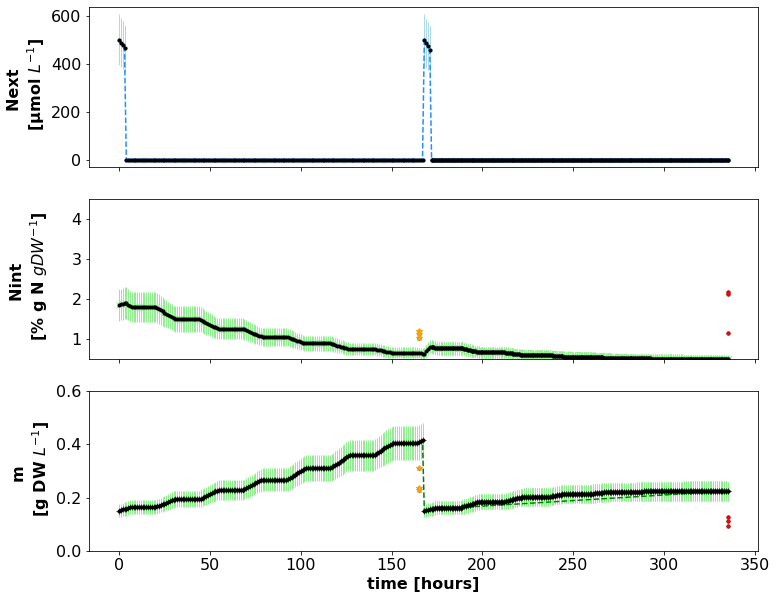

In [7]:
# Simulation of short duration experiment

# We first produce an array ("m/Nint/Next_mod_all") of all model results (hours 1-504) for each treatment
# Next, we organize the experimental data in the "validation" group
# Finally, we plot simulations for each treatment and add the experimental results as dots/stars


TModAll = [] # Each sub-array has the time steps of a specific treatment (periods)
mExpAllTimes_cal,NintExpAllTimes_cal,NextExpAllTimes_cal = [],[],[]
mModAll,NintModAll,NextModAll = [],[],[]
mExpAllTimes_val,NintExpAllTimes_val,NextExpAllTimes_val = [],[],[]
mModAll_val,NintModAll_val,NextModAll_val = [],[],[]
mExpAllTimes_spor,NintExpAllTimes_spor,NextExpAllTimes_spor = [],[],[]
mModAll_spor,NintModAll_spor,NextModAll_spor = [],[],[]

mTimeTemp_spor = 0

Treatments = ['2000/1/4','500/1/4']
Nint0All = ['1.85','1.85']

Temp = 22
S = 39 # fix salinity function and S=40


df2_cal = df2_Reduced
df2_val = df2_Reduced[(np.isnan(df2_Reduced.DW) != True)& (df2.Sporulated == 'No')]
df2_spor = df2[(np.isnan(df2.DW) != True)&(df2.Treatment != 'Acclimation') & (df2.Week <= 3) & (df2.Stage != 'i') & (df2.Sporulated == 'Yes')&(df2.Comment != 'Exclude')]
#df2_spor = df2_Reduced[(np.isnan(df2_Reduced.DW) != True)&(df2_Reduced.Duration == 168) & (df2_Reduced.Sporulated == 'Yes')&(df2_Reduced.Comment != 'Exclude')]


evaluate_model1, evaluate_model2 = [],[]

for i in Treatments:
    print('\nTreatment: ' + str(i))
    # calibration data
    df2Temp_cal = df2_cal[(df2_Reduced.Treatment == i)]
    mTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.DW) != True)]['DW']
    mTimeTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.DW) != True)]['T']
    NintTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.N) != True)]['N']
    NintTimeTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.N) != True)]['T']
    NextTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.NH4) != True)]['NH4']
    NextTimeTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.NH4) != True)]['T']
    
    # validation data
    df2Temp_val = df2_val[(df2_Reduced.Treatment == i)]
    mTemp_val = df2Temp_val[(np.isnan(df2Temp_val.DW) != True)]['DW']
    mTimeTemp_val = df2Temp_val[(np.isnan(df2Temp_val.DW) != True)]['T']
    NintTemp_val = df2Temp_val[(np.isnan(df2Temp_val.N) != True)]['N']
    NintTimeTemp_val = df2Temp_val[(np.isnan(df2Temp_val.N) != True)]['T']
    NextTemp_val = df2Temp_val[(np.isnan(df2Temp_val.NH4) != True)]['NH4']
    NextTimeTemp_val = df2Temp_val[(np.isnan(df2Temp_val.NH4) != True)]['T']
    
    # sporulation data
    del mTimeTemp_spor
    df2Temp_spor = df2_spor[(df2_spor.Treatment == i)]
    mTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.DW) != True)]['DW']
    mTimeTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.DW) != True)]['T']
    NintTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.N) != True)]['N']
    NintTimeTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.N) != True)]['T']
    NextTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.NH4) != True)]['NH4']
    NextTimeTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.NH4) != True)]['T']
    mTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.DW))]['DW']
    mTimeTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.DW))]['T']
    NintTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.N))]['N']
    NintTimeTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.N))]['T']
    NextTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.NH4))]['NH4']
    NextTimeTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.NH4))]['T']
    
    #print('Number of samples:\nm: ' + str(len(mTimeTemp_cal)) + ' Nint: ' + str(len(NintTimeTemp_cal)) + ' Next: ' + str(len(NextTimeTemp_cal)))
    
    # Amplitude (uM NH4) / Period (days between each fertilizing event) / Duration (hours) parameters from input
    Tr = []
    Tr = i.split('/')
    Tr = [float(i) for i in Tr]
    Amplitude = Tr[0]
    Period = float(7/Tr[1]) # Period is in days
    Duration = float(Tr[2])
    
    NEXT, NINT, M, TT = [],[],[],[]

    n_days = Period*2
    count_periods = 0
      
    # hour = 0 is 1pm 
    # at the beginning of the Treatment we reset Nint, Next, m
    # at the beginning of each Period we set Next to the current Next + the Amplitude, 
    # m0 to the end of previous solution of ode()
    
    # Let's prepare the IO(t) function that will be supplied to odeint 
    # instead of a scalar.  
    
    all_treatment_hours = np.arange(0,n_days*24,dtype=np.int)
    
    # 8pm on the first day is zero crossing of this one 8pm - 1am = 7 hours
    offtimes = all_treatment_hours[np.mod(all_treatment_hours - 7,24) == 0]
    offtimes = np.r_[offtimes,all_treatment_hours[-1]+1] # last hour would be whatever
    
    # 6am on the next day is zero crossing of this one, 6am - 8pm is 10 hours
    ontimes = all_treatment_hours[np.mod(all_treatment_hours - 7 + 10,24) == 0]
    # and the inital hour as we always start at 1pm, during ontime
    ontimes = np.r_[np.int(0),ontimes]
    
    # prepare the duty cycle
    I0set = np.zeros_like(all_treatment_hours)
    for s,e in zip(ontimes,offtimes):
        I0set[s:e] = 80
        
    # if you want to replace it by a "constant" I0 (for example 80 umol photons per m^2 per second)
    # then replace the lines above with the following line
    
    # I0set = np.ones_like(all_treatment_hours)*80

    
    I0 = interpolate.interp1d(all_treatment_hours, I0set, bounds_error=False, fill_value="extrapolate")
    
    for hour in [0,Duration,Period*24,Period*24+Duration,n_days*24]: # there is no symetric cycle, but we may find a more elegant way to write it
        print(hour)
        if hour == 0:
            print('Starting point')
            Nint_0 = Nint0All[Treatments.index(i)]
            m_0 = m0
            Next_0 = Amplitude
            t = np.arange(hour, hour+Duration)
            
        elif hour == Duration:
            print('Duration')
            Nint_0 = NINT[-1][-1]
            m_0 = M[-1][-1]
            Next_0 = 0
            t = np.arange(hour, Period*24)
        elif hour == Period*24:
            print('Second week')
            Nint_0 = NINT[-1][-1]
            m_0 = m0
            Next_0 = Amplitude
            t = np.arange(hour, hour+Duration)
        
        elif hour == Duration + Period*24:
            print('Duration')
            Nint_0 = NINT[-1][-1]
            m_0 = M[-1][-1]
            Next_0 = 0
            t = np.arange(hour, n_days*24)             
                
        # Here we want to send odeint the times of the light sub-period or 
        # darkness sub-period

        x0 = [Next_0,Nint_0,m_0]
        x = odeint(controlled_N_constST,x0,t,args=(Nintmax,Nintmin,Vmax,Ks,dNextoutdt,dNextindt,miu,dmoutdt,Nintcrit,Z,KI,K0,Ka,
                losses20,teta,umol_to_percent_DW,I0,Temp),printmessg=0,hmax=.1)

        NEXT.append(x[: , 0])
        NINT.append(x[: , 1])
        M.append(x[: , 2])
        TT.append(t)
        
        t_model = np.hstack(TT)
        Next_model = np.hstack(NEXT)
        Nint_model = np.hstack(NINT)
        m_model = np.hstack(M)

    TModAll.append(TT)

    #model data
    mModAll.append(m_model)
    NintModAll.append(Nint_model)
    NextModAll.append(Next_model)
    
    #Valiaation experimental data
    mExpAllTimes_val.append(mTimeTemp_val)
    NintExpAllTimes_val.append(NintTimeTemp_val)
    NextExpAllTimes_val.append(NextTimeTemp_val)
    
    # error bars according to calibration error
    yerrm1,yerrNext1,yerrNint1 = [],[],[]
    for i in m_model:
        yerrm1.append(0.16*i)
    for i in Nint_model:
        yerrNint1.append(0.21*i)
    for i in Next_model:
        yerrNext1.append(0.21*i)
    
    plot_result_extra(t_model,Next_model,Nint_model,m_model,Nint=NintTemp_cal,yerrNint=yerrNint1,tNint=NintTimeTemp_cal,m=mTemp_cal,yerrm=yerrm1,tm=mTimeTemp_cal,Next=NextTemp_cal,yerrNext=yerrNext1,tNext=NextTimeTemp_cal,Next_val = NextTemp_val,tNext_val =NextTimeTemp_val,Nint_val = NintTemp_val,tNint_val =NintTimeTemp_val,m_val = mTemp_val,tm_val =mTimeTemp_val,Next_spor = NextTemp_spor,tNext_spor =NextTimeTemp_spor,Nint_spor = NintTemp_spor,tNint_spor =NintTimeTemp_spor,m_spor = mTemp_spor,tm_spor =mTimeTemp_spor)
    
    # Fertilizing efficiency by model
    As = Nint_model[167] * m_model[167] / 100 - Nint_model[0] * m_model[0] / 100
    Ad = Amplitude / 1000 * 14 / 1000

    Ef = As / Ad
    print('Fertilizing efficiency of: ' + str(Ef))
    
# calculate errors
mSRE_All,NintSRE_All = [],[]
for j in range(len(Treatments)):
    print(j)
    mSRE,NintSRE = [],[]
    RMSREmAll,RMSRENintAll = [],[]


    #df2m = df2_ReducedTemp[(np.isnan(df2_ReducedTemp.DW) != True)&(df2_ReducedTemp.Treatment == Treatments[j])]
    df2m = df2_val[(np.isnan(df2_val.DW) != True)&(df2_val.Treatment == Treatments[j])]
    l = 0
    for k in df2m.Sample:
        mexp = df2m.DW
        mmod = []
        for i in mTimeTemp_val:
            mmod.append(mModAll[j][i])
        #mmod = mModAll[l][mExpAllTimes_val[l]]
        mSRE.append(((mexp.iloc[l]-mmod[l])/mmod[l])**2)
        #print('mSRE: ' +str(mSRE))
        #mSRE_All.append(((mexp.iloc[l]-mmod[l])/mmod[l])**2)
        l = l + 1
    RMSREm = round((np.mean(mSRE))**0.5,3)

    print('The RMSRE of m in treamtment ' + str(Treatments[j]) + ' is: ' + str(RMSREm) + '\n')

    df2Nint = df2_val[(np.isnan(df2_val.N) != True)][(df2_val.Treatment == Treatments[j])]

    l = 0
    for k in df2Nint.Sample:
        Nintexp = df2Nint.N
        Nintmod = NintModAll[j]
        NintSRE.append(((Nintexp.iloc[l]-Nintmod[l])/Nintmod[l])**2)
        NintSRE_All.append(((Nintexp.iloc[l]-Nintmod[l])/Nintmod[l])**2)      
        l = l + 1
    RMSRENint = round((np.mean(NintSRE))**0.5,3)

    print('The RMSRE of Nint in treamtment ' + str(Treatments[j]) + ' is: ' + str(RMSRENint) + '\n')  

In [8]:
# Fertilizing efficiency by model

As = Nint_model[167] * m_model[167] / 100 - Nint_model[0] * m_model[0] / 100
Ad = Amplitude / 1000 * 14 / 1000

Ef = As / Ad
print(Ef)

-0.020338541651938904


In [9]:
# list of parameters - based on short-duration indoor system culibration - Nintmax between 4.5-5
miu = 0.03
lossess20 = 0.003
Nintmax = 4.6
Nintcrit = 1.68
dNextoutdt = 0.002
Ks = 28.1
Vmax = 56.4
KI = 38.1
K0 = 2.3
Ka = 0.129


Treatment: 2000/1/4
0
Starting point
4.0
Duration


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


168.0
Second week
172.0
Duration
336.0

Treatment: 500/1/4
0
Starting point
4.0
Duration


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


168.0
Second week
172.0
Duration
336.0
0
The RMSRE of m in treamtment 2000/1/4 is: 0.537

The RMSRE of Nint in treamtment 2000/1/4 is: 0.255

1
The RMSRE of m in treamtment 500/1/4 is: 0.425

The RMSRE of Nint in treamtment 500/1/4 is: 0.341



C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:208: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


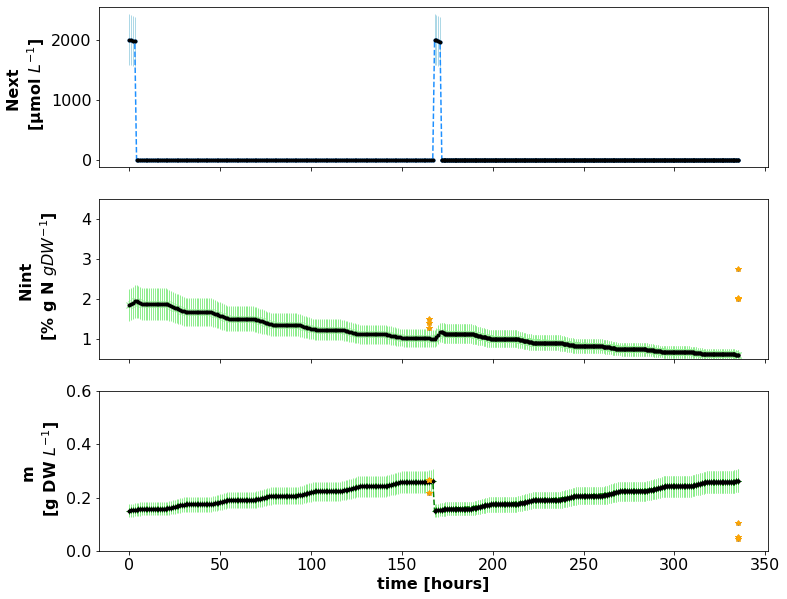

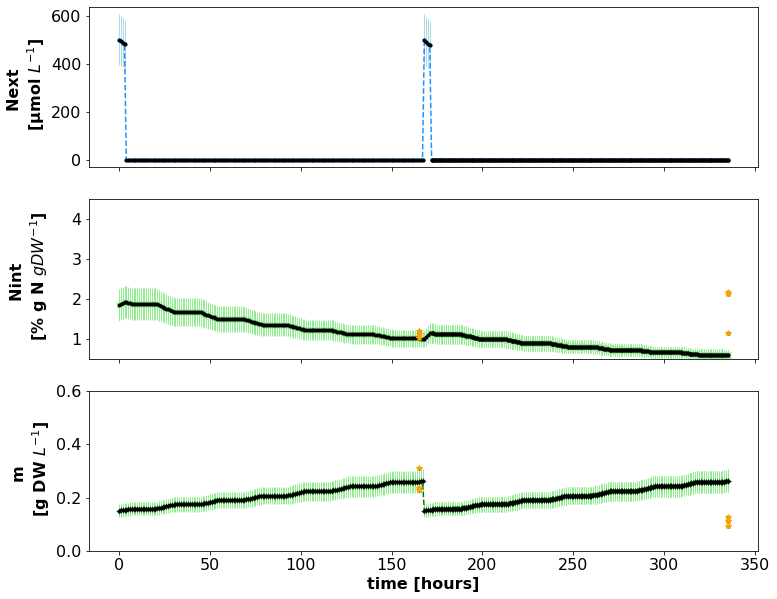

In [10]:
# Simulation of short duration experiment

# We first produce an array ("m/Nint/Next_mod_all") of all model results (hours 1-504) for each treatment
# Next, we organize the experimental data in the "validation" group
# Finally, we plot simulations for each treatment and add the experimental results as dots/stars


TModAll = [] # Each sub-array has the time steps of a specific treatment (periods)
mExpAllTimes_cal,NintExpAllTimes_cal,NextExpAllTimes_cal = [],[],[]
mModAll,NintModAll,NextModAll = [],[],[]
mExpAllTimes_val,NintExpAllTimes_val,NextExpAllTimes_val = [],[],[]
mModAll_val,NintModAll_val,NextModAll_val = [],[],[]
mExpAllTimes_spor,NintExpAllTimes_spor,NextExpAllTimes_spor = [],[],[]
mModAll_spor,NintModAll_spor,NextModAll_spor = [],[],[]

mTimeTemp_spor = 0

Treatments = ['2000/1/4','500/1/4']
Nint0All = ['1.85','1.85']

Temp = 22
S = 39 # fix salinity function and S=40


df2_cal = df2_Reduced
df2_val = df2_Reduced[(np.isnan(df2_Reduced.DW) != True)]
df2_spor = df2[(np.isnan(df2.DW) != True)&(df2.Treatment != 'Acclimation')&(df2.Duration == 168) & (df2.Week <= 3) & (df2.Stage != 'i') & (df2.Sporulated == 'Yes')&(df2.Comment != 'Exclude')]

evaluate_model1, evaluate_model2 = [],[]

for i in Treatments:
    print('\nTreatment: ' + str(i))
    # calibration data
    df2Temp_cal = df2_cal[(df2_Reduced.Treatment == i)]
    mTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.DW) != True)]['DW']
    mTimeTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.DW) != True)]['T']
    NintTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.N) != True)]['N']
    NintTimeTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.N) != True)]['T']
    NextTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.NH4) != True)]['NH4']
    NextTimeTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.NH4) != True)]['T']
    
    # validation data
    df2Temp_val = df2_val[(df2_Reduced.Treatment == i)]
    mTemp_val = df2Temp_val[(np.isnan(df2Temp_val.DW) != True)]['DW']
    mTimeTemp_val = df2Temp_val[(np.isnan(df2Temp_val.DW) != True)]['T']
    NintTemp_val = df2Temp_val[(np.isnan(df2Temp_val.N) != True)]['N']
    NintTimeTemp_val = df2Temp_val[(np.isnan(df2Temp_val.N) != True)]['T']
    NextTemp_val = df2Temp_val[(np.isnan(df2Temp_val.NH4) != True)]['NH4']
    NextTimeTemp_val = df2Temp_val[(np.isnan(df2Temp_val.NH4) != True)]['T']
    
    # sporulation data
    del mTimeTemp_spor
    df2Temp_spor = df2_spor[(df2_spor.Treatment == i)]
    mTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.DW) != True)]['DW']
    mTimeTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.DW) != True)]['T']
    NintTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.N) != True)]['N']
    NintTimeTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.N) != True)]['T']
    NextTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.NH4) != True)]['NH4']
    NextTimeTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.NH4) != True)]['T']
    mTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.DW))]['DW']
    mTimeTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.DW))]['T']
    NintTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.N))]['N']
    NintTimeTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.N))]['T']
    NextTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.NH4))]['NH4']
    NextTimeTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.NH4))]['T']
    
    #print('Number of samples:\nm: ' + str(len(mTimeTemp_cal)) + ' Nint: ' + str(len(NintTimeTemp_cal)) + ' Next: ' + str(len(NextTimeTemp_cal)))
    
    # Amplitude (uM NH4) / Period (days between each fertilizing event) / Duration (hours) parameters from input
    Tr = []
    Tr = i.split('/')
    Tr = [float(i) for i in Tr]
    Amplitude = Tr[0]
    Period = float(7/Tr[1]) # Period is in days
    Duration = float(Tr[2])
    
    NEXT, NINT, M, TT = [],[],[],[]

    n_days = Period*2
    count_periods = 0
      
    # hour = 0 is 1pm 
    # at the beginning of the Treatment we reset Nint, Next, m
    # at the beginning of each Period we set Next to the current Next + the Amplitude, 
    # m0 to the end of previous solution of ode()
    
    # Let's prepare the IO(t) function that will be supplied to odeint 
    # instead of a scalar.  
    
    all_treatment_hours = np.arange(0,n_days*24,dtype=np.int)
    
    # 8pm on the first day is zero crossing of this one 8pm - 1am = 7 hours
    offtimes = all_treatment_hours[np.mod(all_treatment_hours - 7,24) == 0]
    offtimes = np.r_[offtimes,all_treatment_hours[-1]+1] # last hour would be whatever
    
    # 6am on the next day is zero crossing of this one, 6am - 8pm is 10 hours
    ontimes = all_treatment_hours[np.mod(all_treatment_hours - 7 + 10,24) == 0]
    # and the inital hour as we always start at 1pm, during ontime
    ontimes = np.r_[np.int(0),ontimes]
    
    # prepare the duty cycle
    I0set = np.zeros_like(all_treatment_hours)
    for s,e in zip(ontimes,offtimes):
        I0set[s:e] = 80
        
    # if you want to replace it by a "constant" I0 (for example 80 umol photons per m^2 per second)
    # then replace the lines above with the following line
    
    # I0set = np.ones_like(all_treatment_hours)*80

    
    I0 = interpolate.interp1d(all_treatment_hours, I0set, bounds_error=False, fill_value="extrapolate")
    
    for hour in [0,Duration,Period*24,Period*24+Duration,n_days*24]: # there is no symetric cycle, but we may find a more elegant way to write it
        print(hour)
        if hour == 0:
            print('Starting point')
            Nint_0 = Nint0All[Treatments.index(i)]
            m_0 = m0
            Next_0 = Amplitude
            t = np.arange(hour, hour+Duration)
            
        elif hour == Duration:
            print('Duration')
            Nint_0 = NINT[-1][-1]
            m_0 = M[-1][-1]
            Next_0 = 0
            t = np.arange(hour, Period*24)
        elif hour == Period*24:
            print('Second week')
            Nint_0 = NINT[-1][-1]
            m_0 = m0
            Next_0 = Amplitude
            t = np.arange(hour, hour+Duration)
        
        elif hour == Duration + Period*24:
            print('Duration')
            Nint_0 = NINT[-1][-1]
            m_0 = M[-1][-1]
            Next_0 = 0
            t = np.arange(hour, n_days*24)             
                
        # Here we want to send odeint the times of the light sub-period or 
        # darkness sub-period

        x0 = [Next_0,Nint_0,m_0]
        x = odeint(controlled_N_constST,x0,t,args=(Nintmax,Nintmin,Vmax,Ks,dNextoutdt,dNextindt,miu,dmoutdt,Nintcrit,Z,KI,K0,Ka,
                losses20,teta,umol_to_percent_DW,I0,Temp),printmessg=0,hmax=.1)

        NEXT.append(x[: , 0])
        NINT.append(x[: , 1])
        M.append(x[: , 2])
        TT.append(t)
        
        t_model = np.hstack(TT)
        Next_model = np.hstack(NEXT)
        Nint_model = np.hstack(NINT)
        m_model = np.hstack(M)

    TModAll.append(TT)

    #model data
    mModAll.append(m_model)
    NintModAll.append(Nint_model)
    NextModAll.append(Next_model)
    
    #Valiaation experimental data
    mExpAllTimes_val.append(mTimeTemp_val)
    NintExpAllTimes_val.append(NintTimeTemp_val)
    NextExpAllTimes_val.append(NextTimeTemp_val)
    
    # error bars according to calibration error
    yerrm1,yerrNext1,yerrNint1 = [],[],[]
    for i in m_model:
        yerrm1.append(0.16*i)
    for i in Nint_model:
        yerrNint1.append(0.21*i)
    for i in Next_model:
        yerrNext1.append(0.21*i)

    plot_result_extra(t_model,Next_model,Nint_model,m_model,Nint=NintTemp_cal,yerrNint=yerrNint1,tNint=NintTimeTemp_cal,m=mTemp_cal,yerrm=yerrm1,tm=mTimeTemp_cal,Next=NextTemp_cal,yerrNext=yerrNext1,tNext=NextTimeTemp_cal,Next_val = NextTemp_val,tNext_val =NextTimeTemp_val,Nint_val = NintTemp_val,tNint_val =NintTimeTemp_val,m_val = mTemp_val,tm_val =mTimeTemp_val,Next_spor = NextTemp_spor,tNext_spor =NextTimeTemp_spor,Nint_spor = NintTemp_spor,tNint_spor =NintTimeTemp_spor,m_spor = mTemp_spor,tm_spor =mTimeTemp_spor)
    
# calculate errors
mSRE_All,NintSRE_All = [],[]
for j in range(len(Treatments)):
    print(j)
    mSRE,NintSRE = [],[]
    RMSREmAll,RMSRENintAll = [],[]


    #df2m = df2_ReducedTemp[(np.isnan(df2_ReducedTemp.DW) != True)&(df2_ReducedTemp.Treatment == Treatments[j])]
    df2m = df2_val[(np.isnan(df2_val.DW) != True)&(df2_val.Treatment == Treatments[j])]
    l = 0
    for k in df2m.Sample:
        mexp = df2m.DW
        mmod = []
        for i in mTimeTemp_val:
            mmod.append(mModAll[j][i])
        #mmod = mModAll[l][mExpAllTimes_val[l]]
        mSRE.append(((mexp.iloc[l]-mmod[l])/mmod[l])**2)
        #print('mSRE: ' +str(mSRE))
        #mSRE_All.append(((mexp.iloc[l]-mmod[l])/mmod[l])**2)
        l = l + 1
    RMSREm = round((np.mean(mSRE))**0.5,3)

    print('The RMSRE of m in treamtment ' + str(Treatments[j]) + ' is: ' + str(RMSREm) + '\n')

    df2Nint = df2_val[(np.isnan(df2_val.N) != True)][(df2_val.Treatment == Treatments[j])]

    l = 0
    for k in df2Nint.Sample:
        Nintexp = df2Nint.N
        Nintmod = NintModAll[j]
        NintSRE.append(((Nintexp.iloc[l]-Nintmod[l])/Nintmod[l])**2)
        NintSRE_All.append(((Nintexp.iloc[l]-Nintmod[l])/Nintmod[l])**2)      
        l = l + 1
    RMSRENint = round((np.mean(NintSRE))**0.5,3)

    print('The RMSRE of Nint in treamtment ' + str(Treatments[j]) + ' is: ' + str(RMSRENint) + '\n')

In [11]:
# Calibration based on short-term fertilizing results in lrage errors in the long-duration fertilizing

In [12]:
# list of parameters - based on indoor system culibration - Nintmax between 4.5-5
miu = 0.03
lossess20 = 0.001
Nintmax = 4.8
Nintcrit = 1.55
dNextoutdt = 0.013
Ks = 12.1
Vmax = 53.2
KI = 32.9
K0 = 1.3
Ka = 0.033


Treatment: 2000/1/24
0
Starting point
24.0
Duration
168.0
Second week


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


192.0
Duration
336.0

Treatment: 500/1/24
0
Starting point
24.0
Duration
168.0
Second week
192.0
Duration
336.0


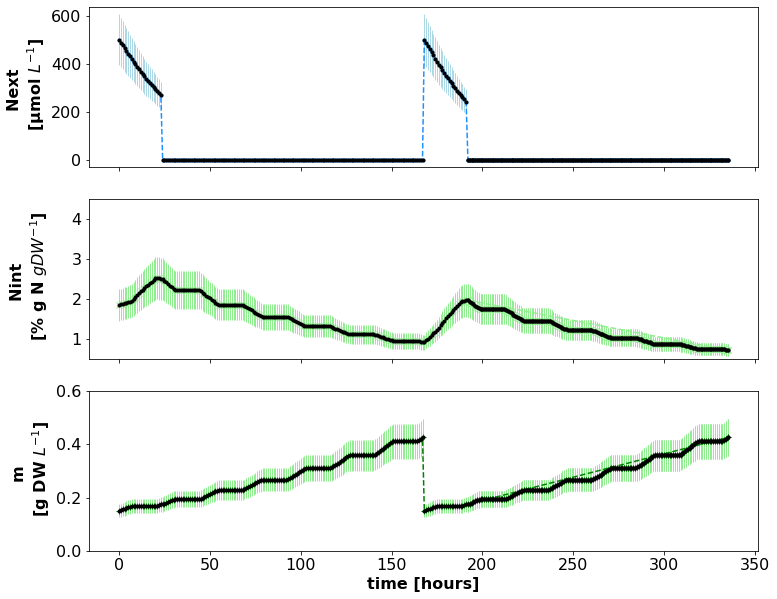

In [13]:
# Simulation of short duration experiment - 24 hours

# We first produce an array ("m/Nint/Next_mod_all") of all model results (hours 1-504) for each treatment
# Next, we organize the experimental data in the "validation" group
# Finally, we plot simulations for each treatment and add the experimental results as dots/stars


TModAll = [] # Each sub-array has the time steps of a specific treatment (periods)
mExpAllTimes_cal,NintExpAllTimes_cal,NextExpAllTimes_cal = [],[],[]
mModAll,NintModAll,NextModAll = [],[],[]
mExpAllTimes_val,NintExpAllTimes_val,NextExpAllTimes_val = [],[],[]
mModAll_val,NintModAll_val,NextModAll_val = [],[],[]
mExpAllTimes_spor,NintExpAllTimes_spor,NextExpAllTimes_spor = [],[],[]
mModAll_spor,NintModAll_spor,NextModAll_spor = [],[],[]

mTimeTemp_spor = 0

Treatments = ['2000/1/24','500/1/24']
Nint0All = ['1.85','1.85']

Temp = 22
S = 39 # fix salinity function and S=40


df2_cal = df2_Reduced
df2_val = df2_Reduced[(np.isnan(df2_Reduced.DW) != True)]
df2_spor = df2[(np.isnan(df2.DW) != True)&(df2.Treatment != 'Acclimation')&(df2.Duration == 168) & (df2.Week <= 3) & (df2.Stage != 'i') & (df2.Sporulated == 'Yes')&(df2.Comment != 'Exclude')]


for i in Treatments:
    print('\nTreatment: ' + str(i))
    # calibration data
    df2Temp_cal = df2_cal[(df2_Reduced.Treatment == i)]
    mTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.DW) != True)]['DW']
    mTimeTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.DW) != True)]['T']
    NintTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.N) != True)]['N']
    NintTimeTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.N) != True)]['T']
    NextTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.NH4) != True)]['NH4']
    NextTimeTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.NH4) != True)]['T']
    
    # validation data
    df2Temp_val = df2_val[(df2_Reduced.Treatment == i)]
    mTemp_val = df2Temp_val[(np.isnan(df2Temp_val.DW) != True)]['DW']
    mTimeTemp_val = df2Temp_val[(np.isnan(df2Temp_val.DW) != True)]['T']
    NintTemp_val = df2Temp_val[(np.isnan(df2Temp_val.N) != True)]['N']
    NintTimeTemp_val = df2Temp_val[(np.isnan(df2Temp_val.N) != True)]['T']
    NextTemp_val = df2Temp_val[(np.isnan(df2Temp_val.NH4) != True)]['NH4']
    NextTimeTemp_val = df2Temp_val[(np.isnan(df2Temp_val.NH4) != True)]['T']
    
    # sporulation data
    del mTimeTemp_spor
    df2Temp_spor = df2_spor[(df2_spor.Treatment == i)]
    mTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.DW) != True)]['DW']
    mTimeTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.DW) != True)]['T']
    NintTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.N) != True)]['N']
    NintTimeTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.N) != True)]['T']
    NextTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.NH4) != True)]['NH4']
    NextTimeTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.NH4) != True)]['T']
    mTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.DW))]['DW']
    mTimeTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.DW))]['T']
    NintTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.N))]['N']
    NintTimeTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.N))]['T']
    NextTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.NH4))]['NH4']
    NextTimeTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.NH4))]['T']
    
    #print('Number of samples:\nm: ' + str(len(mTimeTemp_cal)) + ' Nint: ' + str(len(NintTimeTemp_cal)) + ' Next: ' + str(len(NextTimeTemp_cal)))
    
    # Amplitude (uM NH4) / Period (days between each fertilizing event) / Duration (hours) parameters from input
    Tr = []
    Tr = i.split('/')
    Tr = [float(i) for i in Tr]
    Amplitude = Tr[0]
    Period = float(7/Tr[1]) # Period is in days
    Duration = float(Tr[2])
    
    NEXT, NINT, M, TT = [],[],[],[]

    n_days = Period*2
    count_periods = 0
      
    # hour = 0 is 1pm 
    # at the beginning of the Treatment we reset Nint, Next, m
    # at the beginning of each Period we set Next to the current Next + the Amplitude, 
    # m0 to the end of previous solution of ode()
    
    # Let's prepare the IO(t) function that will be supplied to odeint 
    # instead of a scalar.  
    
    all_treatment_hours = np.arange(0,n_days*24,dtype=np.int)
    
    # 8pm on the first day is zero crossing of this one 8pm - 1am = 7 hours
    offtimes = all_treatment_hours[np.mod(all_treatment_hours - 7,24) == 0]
    offtimes = np.r_[offtimes,all_treatment_hours[-1]+1] # last hour would be whatever
    
    # 6am on the next day is zero crossing of this one, 6am - 8pm is 10 hours
    ontimes = all_treatment_hours[np.mod(all_treatment_hours - 7 + 10,24) == 0]
    # and the inital hour as we always start at 1pm, during ontime
    ontimes = np.r_[np.int(0),ontimes]
    
    # prepare the duty cycle
    I0set = np.zeros_like(all_treatment_hours)
    for s,e in zip(ontimes,offtimes):
        I0set[s:e] = 80
        
    # if you want to replace it by a "constant" I0 (for example 80 umol photons per m^2 per second)
    # then replace the lines above with the following line
    
    # I0set = np.ones_like(all_treatment_hours)*80

    
    I0 = interpolate.interp1d(all_treatment_hours, I0set, bounds_error=False, fill_value="extrapolate")
    
    for hour in [0,Duration,Period*24,Period*24+Duration,n_days*24]: # there is no symetric cycle, but we may find a more elegant way to write it
        print(hour)
        if hour == 0:
            print('Starting point')
            Nint_0 = Nint0All[Treatments.index(i)]
            m_0 = m0
            Next_0 = Amplitude
            t = np.arange(hour, hour+Duration)
            
        elif hour == Duration:
            print('Duration')
            Nint_0 = NINT[-1][-1]
            m_0 = M[-1][-1]
            Next_0 = 0
            t = np.arange(hour, Period*24)
        elif hour == Period*24:
            print('Second week')
            Nint_0 = NINT[-1][-1]
            m_0 = m0
            Next_0 = Amplitude
            t = np.arange(hour, hour+Duration)
        
        elif hour == Duration + Period*24:
            print('Duration')
            Nint_0 = NINT[-1][-1]
            m_0 = M[-1][-1]
            Next_0 = 0
            t = np.arange(hour, n_days*24)             
                
        # Here we want to send odeint the times of the light sub-period or 
        # darkness sub-period

        x0 = [Next_0,Nint_0,m_0]
        x = odeint(controlled_N_constST,x0,t,args=(Nintmax,Nintmin,Vmax,Ks,dNextoutdt,dNextindt,miu,dmoutdt,Nintcrit,Z,KI,K0,Ka,
                losses20,teta,umol_to_percent_DW,I0,Temp),printmessg=0,hmax=.1)

        NEXT.append(x[: , 0])
        NINT.append(x[: , 1])
        M.append(x[: , 2])
        TT.append(t)
        
        t_model = np.hstack(TT)
        Next_model = np.hstack(NEXT)
        Nint_model = np.hstack(NINT)
        m_model = np.hstack(M)

    TModAll.append(TT)

    #model data
    mModAll.append(m_model)
    NintModAll.append(Nint_model)
    NextModAll.append(Next_model)
    
    #Validation experimental data
    mExpAllTimes_val.append(mTimeTemp_val)
    NintExpAllTimes_val.append(NintTimeTemp_val)
    NextExpAllTimes_val.append(NextTimeTemp_val)
    
    # error bars according to calibration error
    yerrm1,yerrNext1,yerrNint1 = [],[],[]
    for i in m_model:
        yerrm1.append(0.16*i)
    for i in Nint_model:
        yerrNint1.append(0.21*i)
    for i in Next_model:
        yerrNext1.append(0.21*i)
        
plot_result_extra(t_model,Next_model,Nint_model,m_model,Nint=NintTemp_cal,yerrNint=yerrNint1,tNint=NintTimeTemp_cal,m=mTemp_cal,yerrm=yerrm1,tm=mTimeTemp_cal,Next=NextTemp_cal,yerrNext=yerrNext1,tNext=NextTimeTemp_cal,Next_val = NextTemp_val,tNext_val =NextTimeTemp_val,Nint_val = NintTemp_val,tNint_val =NintTimeTemp_val,m_val = mTemp_val,tm_val =mTimeTemp_val,Next_spor = NextTemp_spor,tNext_spor =NextTimeTemp_spor,Nint_spor = NintTemp_spor,tNint_spor =NintTimeTemp_spor,m_spor = mTemp_spor,tm_spor =mTimeTemp_spor)


Treatment: 2000/1/20
0
Starting point
20.0
Duration
168.0
Second week


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


188.0
Duration
336.0

Treatment: 500/1/20
0
Starting point
20.0
Duration
168.0
Second week
188.0
Duration
336.0


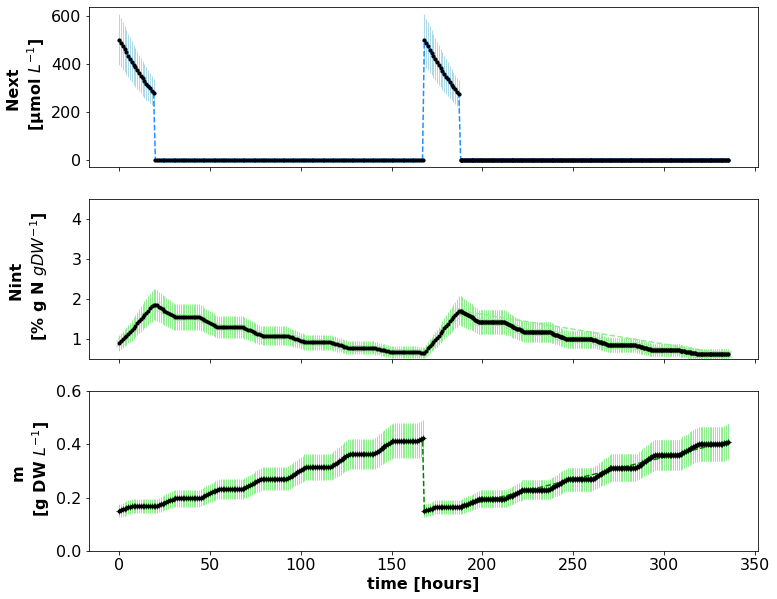

In [14]:
# Simulation of short duration experiment - 20 hours, low initial Nint (like offshore exp)
# simulation predicts growth, but offhosre experiments showed different results

# We first produce an array ("m/Nint/Next_mod_all") of all model results (hours 1-504) for each treatment
# Next, we organize the experimental data in the "validation" group
# Finally, we plot simulations for each treatment and add the experimental results as dots/stars


TModAll = [] # Each sub-array has the time steps of a specific treatment (periods)
mExpAllTimes_cal,NintExpAllTimes_cal,NextExpAllTimes_cal = [],[],[]
mModAll,NintModAll,NextModAll = [],[],[]
mExpAllTimes_val,NintExpAllTimes_val,NextExpAllTimes_val = [],[],[]
mModAll_val,NintModAll_val,NextModAll_val = [],[],[]
mExpAllTimes_spor,NintExpAllTimes_spor,NextExpAllTimes_spor = [],[],[]
mModAll_spor,NintModAll_spor,NextModAll_spor = [],[],[]

mTimeTemp_spor = 0

Treatments = ['2000/1/20','500/1/20']
Nint0All = ['0.9','0.9']

Temp = 22
S = 39 # fix salinity function and S=40


df2_cal = df2_Reduced
df2_val = df2_Reduced[(np.isnan(df2_Reduced.DW) != True)]
df2_spor = df2[(np.isnan(df2.DW) != True)&(df2.Treatment != 'Acclimation')&(df2.Duration == 168) & (df2.Week <= 3) & (df2.Stage != 'i') & (df2.Sporulated == 'Yes')&(df2.Comment != 'Exclude')]


for i in Treatments:
    print('\nTreatment: ' + str(i))
    # calibration data
    df2Temp_cal = df2_cal[(df2_Reduced.Treatment == i)]
    mTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.DW) != True)]['DW']
    mTimeTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.DW) != True)]['T']
    NintTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.N) != True)]['N']
    NintTimeTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.N) != True)]['T']
    NextTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.NH4) != True)]['NH4']
    NextTimeTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.NH4) != True)]['T']
    
    # validation data
    df2Temp_val = df2_val[(df2_Reduced.Treatment == i)]
    mTemp_val = df2Temp_val[(np.isnan(df2Temp_val.DW) != True)]['DW']
    mTimeTemp_val = df2Temp_val[(np.isnan(df2Temp_val.DW) != True)]['T']
    NintTemp_val = df2Temp_val[(np.isnan(df2Temp_val.N) != True)]['N']
    NintTimeTemp_val = df2Temp_val[(np.isnan(df2Temp_val.N) != True)]['T']
    NextTemp_val = df2Temp_val[(np.isnan(df2Temp_val.NH4) != True)]['NH4']
    NextTimeTemp_val = df2Temp_val[(np.isnan(df2Temp_val.NH4) != True)]['T']
    
    # sporulation data
    del mTimeTemp_spor
    df2Temp_spor = df2_spor[(df2_spor.Treatment == i)]
    mTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.DW) != True)]['DW']
    mTimeTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.DW) != True)]['T']
    NintTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.N) != True)]['N']
    NintTimeTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.N) != True)]['T']
    NextTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.NH4) != True)]['NH4']
    NextTimeTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.NH4) != True)]['T']
    mTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.DW))]['DW']
    mTimeTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.DW))]['T']
    NintTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.N))]['N']
    NintTimeTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.N))]['T']
    NextTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.NH4))]['NH4']
    NextTimeTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.NH4))]['T']
    
    #print('Number of samples:\nm: ' + str(len(mTimeTemp_cal)) + ' Nint: ' + str(len(NintTimeTemp_cal)) + ' Next: ' + str(len(NextTimeTemp_cal)))
    
    # Amplitude (uM NH4) / Period (days between each fertilizing event) / Duration (hours) parameters from input
    Tr = []
    Tr = i.split('/')
    Tr = [float(i) for i in Tr]
    Amplitude = Tr[0]
    Period = float(7/Tr[1]) # Period is in days
    Duration = float(Tr[2])
    
    NEXT, NINT, M, TT = [],[],[],[]

    n_days = Period*2
    count_periods = 0
      
    # hour = 0 is 1pm 
    # at the beginning of the Treatment we reset Nint, Next, m
    # at the beginning of each Period we set Next to the current Next + the Amplitude, 
    # m0 to the end of previous solution of ode()
    
    # Let's prepare the IO(t) function that will be supplied to odeint 
    # instead of a scalar.  
    
    all_treatment_hours = np.arange(0,n_days*24,dtype=np.int)
    
    # 8pm on the first day is zero crossing of this one 8pm - 1am = 7 hours
    offtimes = all_treatment_hours[np.mod(all_treatment_hours - 7,24) == 0]
    offtimes = np.r_[offtimes,all_treatment_hours[-1]+1] # last hour would be whatever
    
    # 6am on the next day is zero crossing of this one, 6am - 8pm is 10 hours
    ontimes = all_treatment_hours[np.mod(all_treatment_hours - 7 + 10,24) == 0]
    # and the inital hour as we always start at 1pm, during ontime
    ontimes = np.r_[np.int(0),ontimes]
    
    # prepare the duty cycle
    I0set = np.zeros_like(all_treatment_hours)
    for s,e in zip(ontimes,offtimes):
        I0set[s:e] = 80
        
    # if you want to replace it by a "constant" I0 (for example 80 umol photons per m^2 per second)
    # then replace the lines above with the following line
    
    # I0set = np.ones_like(all_treatment_hours)*80

    
    I0 = interpolate.interp1d(all_treatment_hours, I0set, bounds_error=False, fill_value="extrapolate")
    
    for hour in [0,Duration,Period*24,Period*24+Duration,n_days*24]: # there is no symetric cycle, but we may find a more elegant way to write it
        print(hour)
        if hour == 0:
            print('Starting point')
            Nint_0 = Nint0All[Treatments.index(i)]
            m_0 = m0
            Next_0 = Amplitude
            t = np.arange(hour, hour+Duration)
            
        elif hour == Duration:
            print('Duration')
            Nint_0 = NINT[-1][-1]
            m_0 = M[-1][-1]
            Next_0 = 0
            t = np.arange(hour, Period*24)
        elif hour == Period*24:
            print('Second week')
            Nint_0 = NINT[-1][-1]
            m_0 = m0
            Next_0 = Amplitude
            t = np.arange(hour, hour+Duration)
        
        elif hour == Duration + Period*24:
            print('Duration')
            Nint_0 = NINT[-1][-1]
            m_0 = M[-1][-1]
            Next_0 = 0
            t = np.arange(hour, n_days*24)             
                
        # Here we want to send odeint the times of the light sub-period or 
        # darkness sub-period

        x0 = [Next_0,Nint_0,m_0]
        x = odeint(controlled_N_constST,x0,t,args=(Nintmax,Nintmin,Vmax,Ks,dNextoutdt,dNextindt,miu,dmoutdt,Nintcrit,Z,KI,K0,Ka,
                losses20,teta,umol_to_percent_DW,I0,Temp),printmessg=0,hmax=.1)
        
        NEXT.append(x[: , 0])
        NINT.append(x[: , 1])
        M.append(x[: , 2])
        TT.append(t)
        
        t_model = np.hstack(TT)
        Next_model = np.hstack(NEXT)
        Nint_model = np.hstack(NINT)
        m_model = np.hstack(M)

    TModAll.append(TT)

    #model data
    mModAll.append(m_model)
    NintModAll.append(Nint_model)
    NextModAll.append(Next_model)
    
    #Valiaation experimental data
    mExpAllTimes_val.append(mTimeTemp_val)
    NintExpAllTimes_val.append(NintTimeTemp_val)
    NextExpAllTimes_val.append(NextTimeTemp_val)
    
    # error bars according to calibration error
    yerrm1,yerrNext1,yerrNint1 = [],[],[]
    for i in m_model:
        yerrm1.append(0.16*i)
    for i in Nint_model:
        yerrNint1.append(0.21*i)
    for i in Next_model:
        yerrNext1.append(0.21*i)
        
plot_result_extra(t_model,Next_model,Nint_model,m_model,Nint=NintTemp_cal,yerrNint=yerrNint1,tNint=NintTimeTemp_cal,m=mTemp_cal,yerrm=yerrm1,tm=mTimeTemp_cal,Next=NextTemp_cal,yerrNext=yerrNext1,tNext=NextTimeTemp_cal,Next_val = NextTemp_val,tNext_val =NextTimeTemp_val,Nint_val = NintTemp_val,tNint_val =NintTimeTemp_val,m_val = mTemp_val,tm_val =mTimeTemp_val,Next_spor = NextTemp_spor,tNext_spor =NextTimeTemp_spor,Nint_spor = NintTemp_spor,tNint_spor =NintTimeTemp_spor,m_spor = mTemp_spor,tm_spor =mTimeTemp_spor)

In [15]:
# Simulation of starvation experiment - calculation


TModAll = [] # Each sub-array has the time steps of a specific treatment (periods)
mModAll,NintModAll,NextModAll = [],[],[]

#mTimeTemp_spor = 0

Nint_0 = 3.19
m_0 = 0.15
Next_0 = 0

Temp = 22
S = 39 # fix salinity function and S=40

# Starvation conditions
Amplitude = 0
Period = 7 # Period is in days
Duration = 504

NEXT, NINT, M, TT = [],[],[],[]

n_days = Period*4
count_periods = 0

# hour = 0 is 1pm 
# at the beginning of the Treatment we reset Nint, Next, m
# at the beginning of each Period we set Next to the current Next + the Amplitude, 
# m0 to the end of previous solution of ode()

# Let's prepare the IO(t) function that will be supplied to odeint 
# instead of a scalar.  

all_treatment_hours = np.arange(0,n_days*24,dtype=np.int)

# 8pm on the first day is zero crossing of this one 8pm - 1am = 7 hours
offtimes = all_treatment_hours[np.mod(all_treatment_hours - 7,24) == 0]
offtimes = np.r_[offtimes,all_treatment_hours[-1]+1] # last hour would be whatever

# 6am on the next day is zero crossing of this one, 6am - 8pm is 10 hours
ontimes = all_treatment_hours[np.mod(all_treatment_hours - 7 + 10,24) == 0]
# and the inital hour as we always start at 1pm, during ontime
ontimes = np.r_[np.int(0),ontimes]

# prepare the duty cycle
I0set = np.zeros_like(all_treatment_hours)
for s,e in zip(ontimes,offtimes):
    I0set[s:e] = 80

# if you want to replace it by a "constant" I0 (for example 80 umol photons per m^2 per second)
# then replace the lines above with the following line

# I0set = np.ones_like(all_treatment_hours)*80


I0 = interpolate.interp1d(all_treatment_hours, I0set, bounds_error=False, fill_value="extrapolate")

t = np.arange(0, 0+Duration)


x0 = [Next_0,Nint_0,m_0]
x = odeint(controlled_N_constST,x0,t,args=(Nintmax,Nintmin,Vmax,Ks,dNextoutdt,dNextindt,miu,dmoutdt,Nintcrit,Z,KI,K0,Ka,
                losses20,teta,umol_to_percent_DW,I0,Temp),printmessg=0,hmax=.1)

NEXT.append(x[: , 0])
NINT.append(x[: , 1])
M.append(x[: , 2])
TT.append(t)

t_model = np.hstack(TT)
Next_model = np.hstack(NEXT)
Nint_model = np.hstack(NINT)
m_model = np.hstack(M)

TModAll.append(TT)

#model data
mModAll.append(m_model)
NintModAll.append(Nint_model)
NextModAll.append(Next_model)

In [16]:
j = 0
MIU = []
for i in mModAll[0]:
    #print(i)
    if i > 0.15:
        miu = 100 * (i-j)/j
        MIU.append(miu)
        #print(miu)
    #print(i,j)
    j = i


In [17]:
from array import array
res = np.array(MIU)
len(res)

503

In [18]:
I = 0
A = []
for i in res:  
    
    if i != 0:
        I = I + i
        j = i
    elif j != 0 and i == 0:
        A.append(I)
        I = 0
    else: 
        I = 0
#print(A)
AA = []
for q in A:
    if q != 0:
        AA.append(q)
print(AA)

[11.01469525652486, 16.68183361141106, 16.20206446541115, 15.669071489081256, 15.0859849233218, 14.459028911048328, 13.796929348681324, 13.110725410673135, 12.412626185974068, 11.564202881031411, 8.531056723445667, 5.443479564411322, 3.0640467983253576, 1.3544660537776936, 0.18641791588931025, -0.5846451410346195, -1.0821143954249492, -1.39835867956149, -1.597518645220807, -1.7222149481392068, -1.7999763388817953]


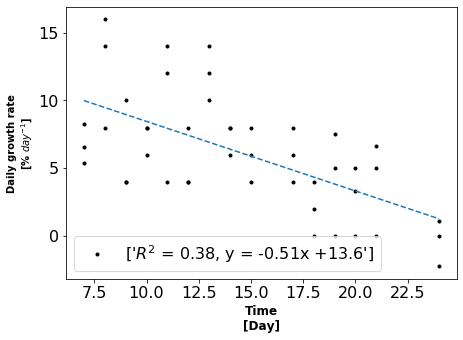

In [19]:
# S.A #1 - Starvation effect on growth rates
from sklearn.linear_model import LinearRegression

x = df2[(df2.Comment == 'Starvation')].Day
y = df2[(df2.Comment == 'Starvation')].GR


fig,ax0 = plt.subplots(1,1,figsize=(7,5))#,sharex=True)
ax0.plot(x,y,'.',markersize=6,color = 'k')

mm, bb = np.polyfit(x, y, 1)
xx = np.array(x).reshape((-1, 1))
model = LinearRegression()
model.fit(xx, y)
model = LinearRegression().fit(xx, y)
r_sq = model.score(xx, y)

ax0.plot(x, mm*x + bb,'--',markersize=6)

ax0.set_ylabel('Daily growth rate\n[% $day^{-1}$]', fontsize=10, weight='bold')
ax0.set_xlabel('Time\n[Day]', fontsize=12, weight='bold')

#ax0.xlabel('Week')
#ax0.ylabel('DGR')

ax0.legend([['$R^{2}$ = ' + str(round(r_sq,2)) + ', y = ' + str(round(mm,2)) + 'x +' + str(round(bb,2))]])

In [20]:
X = []
for i in x:
    j = i + 2
    X.append(j)

RMSRE Nint = 0.14
RMSRE m = 0.452


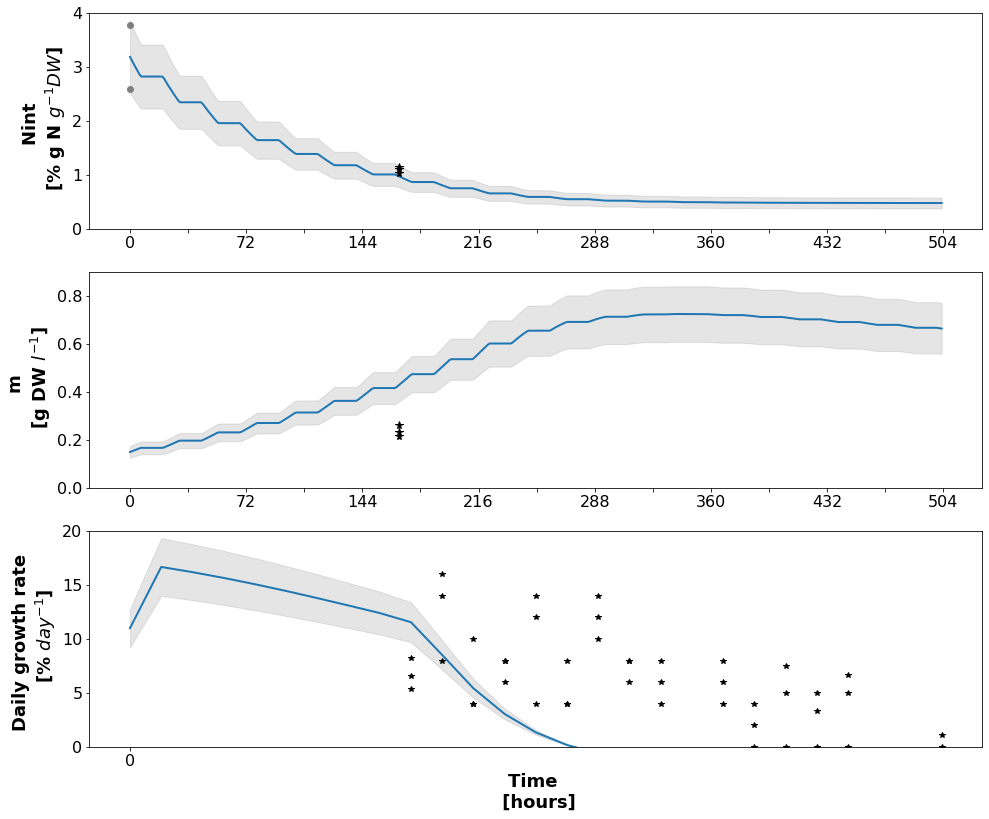

In [21]:
# Plot N and biomass starvation Dynamics

# data and parameters

T = np.arange(0, 600)


xlabels = [
    "0",
    "",
    "72",
    "",
    "144",
    "",
    "216",
    "",
    "288",
    "",
    "360",
    "",
    "432",
    "",
    "504",
]

t = T[0]
I = []
colors = ["turquoise"]#, "dodgerblue", "blue"]
    
fig, ax = plt.subplots(3, 1, figsize=(16, 13.5))


# Plot beauty
ax.flat[0].set_ylim([0, 4])
ax.flat[1].set_ylim([0, m0 * 6])
ax.flat[2].set_ylim([0, 20])

ax.flat[0].set_ylabel(
    "Nint \n [% g N $g^{-1} DW$]", fontsize=18, weight="bold"
)
ax.flat[1].set_ylabel(
    "m \n [g DW $l^{-1}$]", fontsize=18, weight="bold"
)
ax.flat[2].set_ylabel(
    "Daily growth rate \n [% $day^{-1}$]", fontsize=18, weight="bold"
)

ax.flat[2].set_xlabel(
    "Time \n [hours]", fontsize=18, weight="bold"
)

ax.flat[0].set_xticklabels([])
ax.flat[1].set_xticklabels([])
ax.flat[2].set_xticklabels([])
ax.flat[0].set_xticks(np.linspace(0, 21 * 24, 15))
ax.flat[1].set_xticks(np.linspace(0, 21 * 24, 15))
ax.flat[2].set_xticks(np.linspace(0, 21 * 24, 15))


ax.flat[0].set_xticklabels(
    [str(i) for i in xlabels], fontsize=18
)
ax.flat[1].set_xticklabels(
    [str(i) for i in xlabels], fontsize=18
)
ax.flat[2].set_xticklabels(
    [str(i) for i in xlabels], fontsize=18
)


ax.flat[0].set_xticklabels(
    [str(i) for i in xlabels], fontsize=16
)
ax.flat[1].set_xticklabels(
    [str(i) for i in xlabels], fontsize=16
)
ax.flat[2].set_xticklabels(
    [str(i) for i in xlabels], fontsize=16
)

data = np.vstack(NintModAll[0])
ax.flat[0].plot(data,linewidth=2);
ax.flat[0].fill_between(np.arange(data.shape[0]),data.min(axis=1)*.79,data.max(axis=1)*1.21,color="gray",alpha=.2)

Nint_i_all = [2.6, 3.78]
for i in Nint_i_all:
    Nint_i = i
    ax.flat[0].plot(T[0],Nint_i,'o',markersize = 6,color = 'grey')


mSRENint= []
Nint_f_all = [1.15, 1.04, 1.11]
for i in Nint_f_all:
    Nint_f = i
    ax.flat[0].plot(T[167],Nint_f,'*',markersize = 8,color = 'k')
    mSRENint.append(((i-NintModAll[0][167])/NintModAll[0][167])**2)

RMSRENint = round((np.mean(mSRENint))**0.5,3)
print('RMSRE Nint = ' + str(RMSRENint))        
    

mSREm = []
m_f_all = [0.234, 0.261, 0.216]
for i in m_f_all:
    m_f = i
    ax.flat[1].plot(T[167],m_f,'*',markersize = 8,color = 'k')
    mSREm.append(((i-mModAll[0][167])/ mModAll[0][167])**2)

RMSREm = round((np.mean(mSREm))**0.5,3)
print('RMSRE m = ' + str(RMSREm))  
    
    
data = np.vstack(mModAll[0])
ax.flat[1].plot(data,linewidth=2);
ax.flat[1].fill_between(np.arange(data.shape[0]),data.min(axis=1)*.84,data.max(axis=1)*1.16,color="gray",alpha=.2)

data = np.vstack(AA)
ax.flat[2].plot(data,linewidth=2);
ax.flat[2].fill_between(np.arange(data.shape[0]),data.min(axis=1)*.84,data.max(axis=1)*1.16,color="gray",alpha=.2)


ax.flat[2].plot(X,y,'*',markersize = 6,color = 'k')


In [22]:
print(x,y)

371     7.0
372     7.0
373     7.0
374     8.0
375     8.0
376     8.0
377     9.0
378     9.0
379     9.0
380    10.0
381    10.0
382    10.0
383    11.0
384    11.0
385    11.0
386    12.0
387    12.0
388    12.0
389    13.0
390    13.0
391    13.0
392    14.0
393    14.0
394    14.0
395    15.0
396    15.0
397    15.0
398    17.0
399    17.0
400    17.0
401    18.0
402    18.0
403    18.0
404    19.0
405    19.0
406    19.0
407    20.0
408    20.0
409    20.0
410    21.0
411    21.0
412    21.0
413    24.0
414    24.0
415    24.0
Name: Day, dtype: float64 371     6.558777
372     8.234117
373     5.347252
374    14.000000
375    16.000000
376     8.000000
377     4.000000
378    10.000000
379     4.000000
380     8.000000
381     6.000000
382     8.000000
383    12.000000
384    14.000000
385     4.000000
386     4.000000
387     4.000000
388     8.000000
389    14.000000
390    12.000000
391    10.000000
392     8.000000
393     6.000000
394     8.000000
395     6.000000
396     8